In [2]:
import math
import os
import random
import torch
from d2l import torch as d2l

# read dataset
The dataset we use here is Penn Tree Bank (PTB) 191. The corpus is taken from the "Wall Street Journal" article and is divided into training set, validation set and test set. In raw format, each line of the text file represents a sentence separated by spaces. Here, we treat each word as a token.

In [26]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')


def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

In [27]:
sentences = read_ptb()
print(f'# Number of sentences: {len(sentences)}')

# Number of sentences: 42069


In [5]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

# subsample

In [6]:
def subsample(sentences, vocab):
    """
    subsample high frequency words
    """
    # Exclude unknown tokens '<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    def keep(token):
        return random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens)

    return [[token for token in line if keep(token)] for line in sentences], counter


subsampled, counter = subsample(sentences, vocab)

In [7]:
print(counter)

Counter({'the': 50770, 'N': 32481, 'of': 24400, 'to': 23638, 'a': 21196, 'in': 18000, 'and': 17474, "'s": 9784, 'that': 8931, 'for': 8927, '$': 7541, 'is': 7337, 'it': 6112, 'said': 6027, 'on': 5650, 'by': 4915, 'at': 4894, 'as': 4833, 'from': 4724, 'million': 4627, 'with': 4585, 'mr.': 4326, 'was': 4073, 'be': 3923, 'are': 3914, 'its': 3846, 'he': 3632, 'but': 3541, 'has': 3494, 'an': 3477, "n't": 3388, 'will': 3270, 'have': 3245, 'new': 2793, 'or': 2704, 'company': 2680, 'they': 2562, 'this': 2438, 'year': 2379, 'which': 2362, 'would': 2308, 'about': 2220, 'says': 2092, 'more': 2065, 'were': 2009, 'market': 2005, 'billion': 1881, 'his': 1852, 'had': 1850, 'their': 1838, 'up': 1785, 'u.s.': 1774, 'one': 1764, 'than': 1731, 'who': 1695, 'some': 1668, 'been': 1667, 'also': 1617, 'stock': 1611, 'other': 1566, 'share': 1511, 'not': 1451, 'we': 1397, 'corp.': 1288, 'if': 1281, 'when': 1272, 'i': 1262, 'last': 1255, 'president': 1246, 'shares': 1246, 'years': 1241, 'all': 1227, 'first': 118

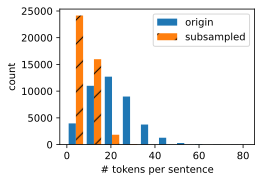

In [8]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence', 'count', sentences, subsampled)

In [9]:
def compare_counts(token):
    return (
        f'number of "{token}": 'f'before={sum([l.count(token) for l in sentences])}, 'f'after={sum([l.count(token) for l in subsampled])}')


compare_counts('the')

'number of "the": before=50770, after=2071'

In [10]:
compare_counts('join')

'number of "join": before=45, after=45'

In [11]:
# After subsampling, we map the tokens to their indices in the corpus.
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 145], [22, 140, 5277, 3054, 1580]]

# Extraction of center and context words

In [14]:
def get_centers_and_contexts(corpus, max_window_size):
    """
    Returns the centers and contexts words in the skip-gram model
    :param corpus:
    :param max_window_size:
    :return: centers, contexts
    """
    centers, contexts = [], []
    for line in corpus:
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [16]:
print('tiny_dataset', corpus[1:3])
for center, context in zip(*get_centers_and_contexts(corpus[1:3], 2)):
    print('The context word of center word', center, 'is', context)

tiny_dataset [[392, 2115, 145], [22, 140, 5277, 3054, 1580]]
The context word of center word 392 is [2115]
The context word of center word 2115 is [392, 145]
The context word of center word 145 is [2115]
The context word of center word 22 is [140, 5277]
The context word of center word 140 is [22, 5277, 3054]
The context word of center word 5277 is [140, 3054]
The context word of center word 3054 is [140, 5277, 1580]
The context word of center word 1580 is [3054]


In [17]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
print(f'# “中⼼词-上下⽂词对”的数量: {sum([len(contexts) for contexts in all_contexts])}')

# “中⼼词-上下⽂词对”的数量: 1500870


# negative sampling

In [19]:
class RandomGenerator:
    """
    根据n个采样权重在{1,...,n}中随机抽取
    """

    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [21]:
# RandomGenerator sample
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 3, 3, 3, 1, 3, 2, 3, 2]

In [22]:
def get_negatives(all_contexts, vocab, counter, k):
    """
    Returns noise words in negative samples
    :param all_contexts
    :param vocab
    :param counter
    :param k
    :return:all_negatives
    """
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)] ** 0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * k:
            neg = generator.draw()
            # 噪声词不能是上下⽂词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives


all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [23]:
all_negatives[:3]

[[2303, 177, 711, 341, 59, 219, 3990, 3269, 52, 6693],
 [4110, 580, 47, 386, 180, 353, 113, 5666, 44, 909],
 [3042, 3245, 58, 31, 5280, 525, 4108, 835, 5429, 1279]]

# ⼩批量加载训练实例

**在提取所有中⼼词及其上下⽂词和采样噪声词后，将它们转换成⼩批量的样本，在训练过程中可以迭代加载。在⼩批量中，$i^{th}$个样本包括中⼼词及其$n^i$个上下⽂词和$m^i$个噪声词。由于上下⽂窗⼝⼤⼩不同，$n^i + m^i$对于不同的i是不同的。因此，对于每个样本，我们在contexts_negatives个变量中将其上下⽂词和噪声词连结起来，并填充零，直到连结⻓度达到$max_{i}n^i+m_{i}$(max_len)。为了在计算损失时排除填充，我们定义了掩码变量masks。在masks中的元素和contexts_negatives中的元素之间存在⼀⼀对应关系，其中masks中的0（否则为1）对应于contexts_negatives中的填充。**
**为了区分正反例，我们在contexts_negatives中通过⼀个labels变量将上下⽂词与噪声词分开。类似于masks，在labels中的元素和contexts_negatives中的元素之间也存在⼀⼀对应关系，其中labels中的1（否则为0）对应于contexts_negatives中的上下⽂词的正例。**
**上述思想在下⾯的batchify函数中实现。其输⼊data是⻓度等于批量⼤⼩的列表，其中每个元素是由中⼼词center、其上下⽂词context和其噪声词negative组成的样本。此函数返回⼀个可以在训练期间加载⽤于计算的⼩批量，例如包括掩码变量。**

In [24]:
def batchify(data):
    """返回带有负采样的跳元模型的⼩批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return torch.tensor(centers).reshape((-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks), torch.tensor(
        labels)


**让我们使⽤⼀个⼩批量的两个样本来测试此函数。**

In [25]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))
names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


#  整合代码
**最后，我们定义了读取PTB数据集并返回数据迭代器和词表的load_data_ptb函数。**

In [29]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return self.centers[index], self.contexts[index], self.negatives[index]

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, collate_fn=batchify,
                                            num_workers=num_workers)
    return data_iter, vocab

***让我们打印数据迭代器的第⼀个⼩批量。***

In [30]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape', data.shape)
    break

centers shape torch.Size([512, 1])
contexts_negatives shape torch.Size([512, 60])
masks shape torch.Size([512, 60])
labels shape torch.Size([512, 60])
